# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [354]:
#Other packages needed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets
import pandas as pd
import re 

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

### Artificially constructed data

In [3]:
# generate 10 distinct artificial data sets
noise = .2
dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
noise = .3
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) 
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
noise = .5
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) 
dfTrain10, dfTest10 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))

train_dfs = [dfTrain1, dfTrain2, dfTrain3, dfTrain4, dfTrain5, dfTrain6, dfTrain7, dfTrain8, dfTrain9, dfTrain10]
test_dfs = [dfTest1, dfTest2, dfTest3, dfTest4, dfTest5, dfTest6, dfTest7, dfTest8, dfTest9, dfTest10]

In [4]:
#define classifiers

#Bayes
bayes = sklearn.naive_bayes.GaussianNB()
#Analogizes
svm_linear = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
svm_poly = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
knn = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
#Classical Regression
linear = sklearn.linear_model.LogisticRegression()
#Symbolists
dt = sklearn.tree.DecisionTreeClassifier()
rf = sklearn.ensemble.RandomForestClassifier()
#Connectionists
mlp = sklearn.neural_network.MLPClassifier()
#Ensemble
gb = sklearn.ensemble.GradientBoostingClassifier()

models = [bayes, svm_linear, svm_poly, knn, linear, dt, rf, mlp, gb]
model_names = ['Bayes','Linear SVM', 'Poly SVM', 'KNN', 'Linear Regression', 
               'Decision Tree','Random Forest', 'MLP', 'Gradient Boosting']

In [5]:
#loop through 10 data & all classifiers
def train_classifiers(train_dfs, test_dfs, models, model_names):
    indices = []
    model_used = []
    auc = []
    for i in range(len(train_dfs)):
        for j in range(len(models)):
            indices.append(i)
            model_used.append(model_names[j])
            model = models[j]
            model.fit(np.stack(train_dfs[i]['vect'], axis=0), train_dfs[i]['category'])
            auc.append(lucem_illud_2020.evaluateClassifier(model,test_dfs[i])['AUC'][0])
    return indices, model_used, auc

In [6]:
indices, model_used, auc = train_classifiers(train_dfs, test_dfs, models, model_names)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reache

In [7]:
res = pd.DataFrame(list(zip(indices, model_used, auc)), columns = ['dataset','model','auc'])

In [8]:
data = [0,1,2,3,4,5,6,7,8,9]
for each in data:
    temp = res[res['dataset']==each]
    max_auc = temp['auc'].max()
    model = list(temp[temp['auc']==max_auc]['model'])[0]
    print("For generated dataset", each, "the best model is", model, "with AUC", max_auc)

For generated dataset 0 the best model is Random Forest with AUC 0.532051282051282
For generated dataset 1 the best model is KNN with AUC 0.9156602254428341
For generated dataset 2 the best model is MLP with AUC 0.9362705740666399
For generated dataset 3 the best model is MLP with AUC 0.9232809528575718
For generated dataset 4 the best model is Poly SVM with AUC 0.8838141025641024
For generated dataset 5 the best model is Gradient Boosting with AUC 0.8792913622260035
For generated dataset 6 the best model is MLP with AUC 0.8403840384038405
For generated dataset 7 the best model is Poly SVM with AUC 0.8170426065162908
For generated dataset 8 the best model is Poly SVM with AUC 0.8140437544107268
For generated dataset 9 the best model is Bayes with AUC 0.7041704625974288


    The above descriptions showed that more complex models generally worked better, most of the  datasets were better classified by more complex models such as Neural Network (MLP) and poly SVM. However, different rendered different results. There was no fix pattern in which model did best when I ran multiple trials.

### Empirical datasets (which worked best and why)

In [23]:
redditTrain, redditTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
newsTrain, newsTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
smallsenateTrain, smallsenateTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
largesenateTrain, largesenateTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
spamTrain, spamTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [31]:
#check each data's general structure
spamTrain.head(1)

,category,text,is_spam,binary,tokenized_text,normalized_text,vect
226,spam,Interest Rates at Forty Yr. Lows,True,True,"[Interest, Rates, at, Forty, Yr, Lows]","[interest, rate, yr, low]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [32]:
emp_train_dfs = [redditTrain, newsTrain, smallsenateTrain, largesenateTrain, spamTrain]
emp_test_dfs = [redditTest, newsTest, smallsenateTest, largesenateTest, spamTest]

In [36]:
#loop through data and classifiers
indices_emp, model_emp, auc_emp = train_classifiers(emp_train_dfs, emp_test_dfs, models, model_names)

In [37]:
#store results into a dataframe
emp_res = pd.DataFrame(list(zip(indices_emp, model_emp, auc_emp)), columns = ['dataset','model','auc'])

In [38]:
data = [0,1,2,3,4]
data_name = ['Reddit', 'News', 'Small Senate', 'Large Senate', 'Spam']
for each in data:
    temp = emp_res[emp_res['dataset']==each]
    max_auc = temp['auc'].max()
    model = list(temp[temp['auc']==max_auc]['model'])[0]
    print("For dataset", data_name[each], "the best model is", model, "with AUC", max_auc)

For dataset Reddit the best model is Linear Regression with AUC 0.9979253112033195
For dataset News the best model is Linear Regression with AUC 0.9467058056099152
For dataset Small Senate the best model is Linear SVM with AUC 1.0
For dataset Large Senate the best model is Decision Tree with AUC 1.0
For dataset Spam the best model is Bayes with AUC 0.8249005305039788


    It is interesting to see that linear regression achieved the best classification result for both reddit and news dataset. For small senate data set, linear SVM and Gradient Boosting did equally well in that they all have perfect AUC. For large senate data, random forest and gradient boosting did equally well with decision tree: they also all have perfect AUC, which suggest that the large senate data's underlying pattern might be better suited with tree-based methods. For the last spam dataset, Bayes classifier had the best performance with an AUC of 0.825.  

### AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)

In [44]:
ada.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
lucem_illud_2020.evaluateClassifier(ada,dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.885,0.866667,0.833667,0.91
1,0.115,0.885,0.905263,0.848526,0.86


    Previously, we see that MLP performed best with dataset 1 (or dfTrain2) with an AUC of 0.91. Adaptive boosting performed worse than MLP, but was still able to achieve am impressive AUC of 0.885. 

In [45]:
ada.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
lucem_illud_2020.evaluateClassifier(ada, redditTrain)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Tales From Tech Support,0.026583,0.973994,0.923529,0.906839,0.975155
Weeaboo Tales,0.010164,0.980786,0.996774,0.968894,0.962617
Relationships,0.024238,0.969022,0.946708,0.915712,0.955696
Bad Roommates,0.035966,0.946865,0.941935,0.881408,0.912500


    Previously, linear regression performed best with classifying Reddit data category (AUC = 0.9979253112033195). Ada Boost also performed great with the data, achieving an average AUC of around 0.96. It is possible that the underlying data structure is actually linear, which might be why linear regression did better than more complex boosting model.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


**For the following analysis, a ready made kaggle dataset is used. The data includes 250000+ lyrics by over 2k singers. (Link: https://www.kaggle.com/detkov/lyrics-dataset#songs_dataset.csv) I intend to use this data to train classifiers, and see if they can separate singers from one another based on vectorized lyrics.**

In [546]:
#read in data
songs = pd.read_csv('songs_dataset.csv')

In [547]:
#select interested singers
wz = songs[songs['Singer']=='Wiz Khalifa'][['Singer','Song','Lyrics']].reset_index()
ts = songs[songs['Singer']=='Taylor Swift'][['Singer','Song','Lyrics']].reset_index()
madonna = songs[songs['Singer']=='Madonna'][['Singer','Song','Lyrics']].reset_index()
mj = songs[songs['Singer']=='Michael Jackson'][['Singer','Song','Lyrics']].reset_index()

In [548]:
#define a function to clean lyrics
def clean_lyrics(lyrics):
    lyrics = re.sub("[\(\[].*?[\)\]]", "", lyrics)
    lyrics = re.sub('\s+', ' ', lyrics)
    return lyrics.strip()

**The singers that will be included in this exercise are Michael Jackson and Taylor Swift (because I intend to build binary classifier).**

In [556]:
#concat into one dataframe
singers = pd.concat([ts,mj], ignore_index=True).drop(['index'], axis=1)
#rename columns
singers.columns = ['category','song','lyrics']
#clean the lyrics
singers['lyrics'] = singers['lyrics'].apply(clean_lyrics)
#drop duplicates
singers = singers.drop_duplicates()

In [557]:
singers.category.value_counts()

Michael Jackson    345
Taylor Swift       301
Name: category, dtype: int64

In [558]:
#apply tfidf vectorizer
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(singers['lyrics'])
singers['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [559]:
#train test split
holdBackFraction = .2
singers_train, singers_test = lucem_illud_2020.trainTestSplit(singers, holdBackFraction=holdBackFraction)

**Logistic Regression**

In [570]:
#pca for train
pca = sklearn.decomposition.PCA()
reduced_data_train = pca.fit_transform(np.stack(singers_train['vect'], axis=0))
singers_train['pca'] = [r for r in reduced_data_train]

#pca for test
reduced_data_test = pca.fit_transform(np.stack(singers_test['vect'], axis=0))
singers_test['pca'] = [r for r in reduced_data_test]

#limit to first 7 PCs
singers_train['pca_reduced'] = singers_train['pca'].apply(lambda x: x[:7])
singers_test['pca_reduced'] = singers_test['pca'].apply(lambda x: x[:7])

#fit logistic regression
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(singers_train['pca_reduced'], axis=0), singers_train['category'])

#print score
print('Training set performance:')
print(logistic.score(np.stack(singers_train['pca_reduced'], axis=0), singers_train['category']))
print('Testing set performance')
print(logistic.score(np.stack(singers_test['pca_reduced'], axis=0), singers_test['category']))

Training set performance:
0.6711798839458414
Testing set performance
0.49612403100775193


In [574]:
logistic= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic.fit(np.stack(singers_train['vect'], axis=0), singers_train['category'])
print('Logistic Regression Train performance')
print(logistic.score(np.stack(singers_train['vect'], axis=0), singers_train['category']))
print('Logistic Regression Test performance')
print(logistic.score(np.stack(singers_test['vect'], axis=0), singers_test['category']))

Logistic Regression Train performance
0.9922630560928434
Logistic Regression Test performance
0.9302325581395349


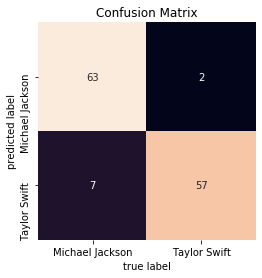

In [575]:
lucem_illud_2020.plotConfusionMatrix(logistic, singers_test)

In [576]:
#save result to dataframe
singers_test['lr_predict'] = logistic.predict(np.stack(singers_test['vect'], axis=0))

#setting michael jackson as the positive label
print('Precision')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['lr_predict'], pos_label='Michael Jackson'))
print('Recall')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['lr_predict'], pos_label='Michael Jackson'))
print('F1')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['lr_predict'], pos_label='Michael Jackson'))

Precision
0.9692307692307692
Recall
0.9
F1
0.9333333333333333


    Logistic regression with L2 penalty trained on vectorized lyrics performed much better than logistic regression trained on reduced pca.
    Logistic regression with L2 penalty can distinguish Taylor Swift from Michael Jackson with a 0.986 accuracy in the training data set, in testing data, the classifier also achieved an accuracy of 0.86.

**Naive Baiyes**

In [562]:
#fit naive bayes
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(singers_train['vect'], axis=0), singers_train['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [563]:
#pring performance
print("Training:")
print(naiveBayes.score(np.stack(singers_train['vect'], axis=0), singers_train['category']))
print("Testing:")
print(naiveBayes.score(np.stack(singers_test['vect'], axis=0), singers_test['category']))

Training:
0.9690522243713733
Testing:
0.9612403100775194


    Naive Bayes did equally well in classifiying singers from each other in the training data (accuracy of 0.978). Moreover, Naive Bayes is able to achieve an even higher accuracy in testing data set (0.938).

In [564]:
#save result to dataframe
singers_test['nb_predict'] = naiveBayes.predict(np.stack(singers_test['vect'], axis=0))
singers_test['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(singers_test['vect'], axis=0))[:,0] 

In [565]:
singers_test.head(5)

,category,song,lyrics,vect,pca,pca_reduced,nb_predict,nb_predict_prob_true
577,Michael Jackson,I Am a Loser,"You laughed at me, you made me cry You made a ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.028720773644138893, 0.011708255853360784, ...","[-0.028720773644138893, 0.011708255853360784, ...",Michael Jackson,9.951036e-01
485,Michael Jackson,Scream (Naughty Radio Edit),Aahh... Hoo... Aahh... Hoo.. Tired of injustic...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04700976533284182, 0.932045824503209, -0.0...","[-0.04700976533284182, 0.932045824503209, -0.0...",Michael Jackson,1.000000e+00
240,Taylor Swift,Live For The Little Things,"One daybreak, one heartache Every once-upon-a-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.023820029728065926, -0.03628158277816651, ...","[-0.023820029728065926, -0.03628158277816651, ...",Taylor Swift,3.844227e-07
283,Taylor Swift,Lover (Piano/Vocal),"Writing the song ""Lover"" was one of those magi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0565900113534102, -0.04326180174620212, -0...","[-0.0565900113534102, -0.04326180174620212, -0...",Taylor Swift,7.364579e-25
544,Michael Jackson,Xscape,"Everywhere I turn, no matter where I look The ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0043707401046898095, -0.008607902249233045...","[-0.0043707401046898095, -0.008607902249233045...",Michael Jackson,9.997185e-01


In [455]:
#setting michael jackson as the positive label
print('Precision')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['nb_predict'], pos_label='Michael Jackson'))
print('Recall')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['nb_predict'], pos_label='Michael Jackson'))
print('F1')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['nb_predict'], pos_label='Michael Jackson'))

Precision
0.9382716049382716
Recall
0.9620253164556962
F1
0.95


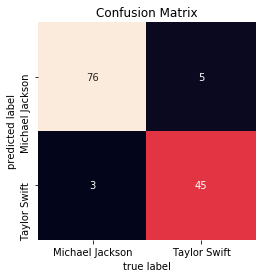

In [456]:
lucem_illud_2020.plotConfusionMatrix(naiveBayes, singers_test)

    The naive bayes classifier performed surprisingly well! It classified most of Michael Jackson adn Taylor Swift's songs correctly in the testing data set.

In [577]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Michael Jackson' : [],
    'michael_log_prob' : [],
    'Taylor Swift' : [],
    'taylor_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Michael Jackson'].append(TFVectorizer.get_feature_names()[i])
    words_dict['michael_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Taylor Swift'].append(TFVectorizer.get_feature_names()[i])
    words_dict['taylor_log_prob'].append(prob)
    
words_dict = pandas.DataFrame(words_dict)

In [582]:
words_dict

,Michael Jackson,michael_log_prob,Taylor Swift,taylor_log_prob
0,ooh,-1.480883,little,-1.565343
1,man,-1.732197,home,-1.647021
2,stop,-1.752816,thought,-1.647021
3,try,-1.752816,didn,-1.668527
4,came,-1.862817,better,-1.759499
5,stay,-1.862817,did,-1.808289
6,ain,-1.886348,smile,-1.808289
7,inside,-1.886348,knew,-1.833607
8,soul,-1.886348,ain,-1.859582
9,feeling,-1.935138,fall,-1.859582


      The above table shows the most influential words in distinguishing the singers apart. Michael Jackson apparently use words such as 'man', 'soul' and 'people', whereas Taylor Swift used words such as 'little', 'home', 'smile'. These results intuitively make sense because these words do give me very distinct feelings. Michael Jackson is more 'classic' and vintage, whereas Taylor Swift tends to be more emotional and sensitive.

# Decision Trees

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

**For this exercise, I will build multi-class classifier. Madonna and Wizkhalifa would be added to the data.**

In [566]:
#concat into one dataframe
singers = pd.concat([wiz, mj, ts, madonna], ignore_index=True).drop(['index'], axis=1)
#rename columns
singers.columns = ['category','song','lyrics']
#clean the lyrics
singers['lyrics'] = singers['lyrics'].apply(clean_lyrics)
#drop duplicates
singers = singers.drop_duplicates()

In [567]:
#check how many songs are included
singers.category.value_counts()

Wiz Khalifa        574
Madonna            423
Michael Jackson    345
Taylor Swift       301
Name: category, dtype: int64

In [485]:
#apply tfidf vectorizer
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(singers['lyrics'])
singers['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#train test split
holdBackFraction = .2
singers_train, singers_test = lucem_illud_2020.trainTestSplit(singers, holdBackFraction=holdBackFraction)

In [486]:
#make sure test data have all 4 singers
singers_test.category.value_counts()

Wiz Khalifa        116
Madonna             82
Michael Jackson     67
Taylor Swift        63
Name: category, dtype: int64

In [487]:
#make sure train data have all 4 singers
singers_train.category.value_counts()

Wiz Khalifa        458
Madonna            341
Michael Jackson    278
Taylor Swift       238
Name: category, dtype: int64

**Decision Tree**

In [492]:
#fit and train decision tree
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=2)
clf_tree.fit(np.stack(singers_train['vect'], axis =0), singers_train['category'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='best')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

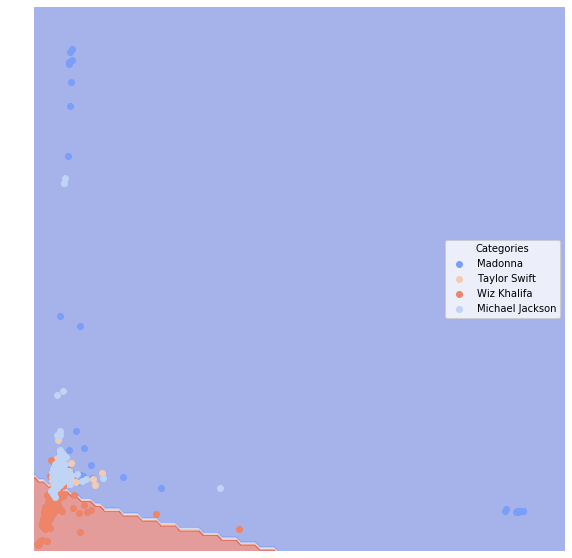

In [493]:
#visualize performance
lucem_illud_2020.plotregions(clf_tree, singers_train)

In [494]:
#evaluate decision tree classifier
lucem_illud_2020.evaluateClassifier(clf_tree, singers_test)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Madonna,0.588415,0.599593,0.295203,0.294100,0.975610
Taylor Swift,0.192073,0.500000,0.000000,0.192073,0.000000
Wiz Khalifa,0.198171,0.723731,0.963636,0.632355,0.456897
Michael Jackson,0.204268,0.505547,0.500000,0.208682,0.014925


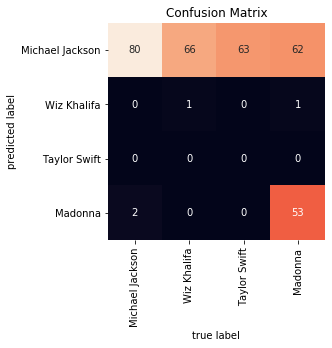

In [495]:
lucem_illud_2020.plotConfusionMatrix(clf_tree, singers_test)

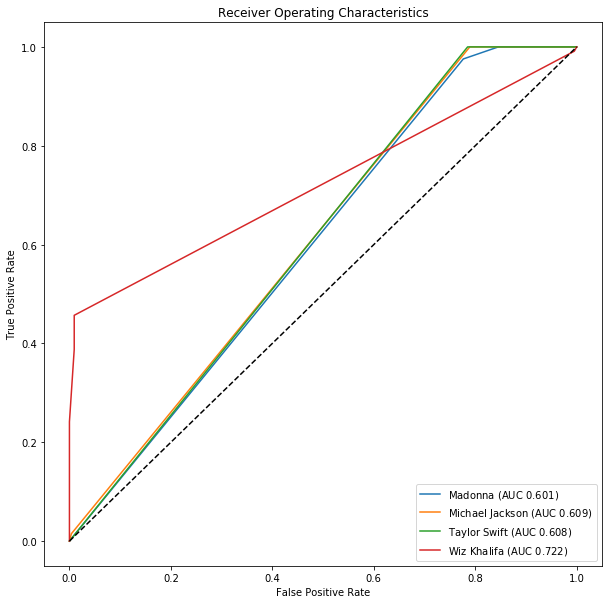

In [512]:
lucem_illud_2020.plotMultiROC(clf_tree, singers_test)

In [529]:
#save result to dataframe
singers_test['dt_predict'] = clf_tree.predict(np.stack(singers_test['vect'], axis=0))
singers_test['dt_predict_prob_true'] = clf_tree.predict_proba(np.stack(singers_test['vect'], axis=0))[:,0]

#evaluate
print('Precision')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['dt_predict'], average='weighted'))
print('Recall')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['dt_predict'], average='weighted'))
print('F1')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['dt_predict'], average='weighted'))

Precision
0.5167331105129234
Recall
0.40853658536585363
F1
0.3384621967812304


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    We see from the above table and graph that our trained decision tree classifier doesn't perform that well on test data. 

**Random Forest**

In [498]:
#now let's bag different trees together
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) 
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, 
                                         max_samples=0.8, random_state=2) #Each tree uses up to 80% of the data

In [499]:
bag.fit(np.stack(singers_train['vect'], axis =0), singers_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

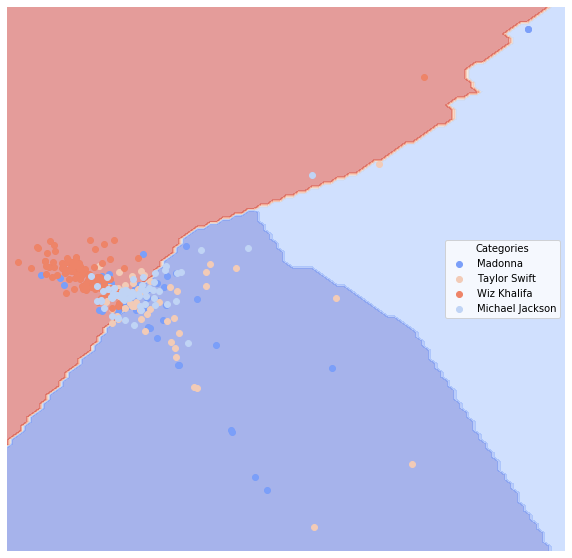

In [500]:
lucem_illud_2020.plotregions(bag, singers_test)

In [501]:
lucem_illud_2020.evaluateClassifier(bag, singers_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Madonna,0.375000,0.725610,0.393782,0.383262,0.926829
Taylor Swift,0.167683,0.581641,0.785714,0.295725,0.174603
Wiz Khalifa,0.051829,0.934532,0.962617,0.894371,0.887931
Michael Jackson,0.192073,0.557586,0.642857,0.263183,0.134328


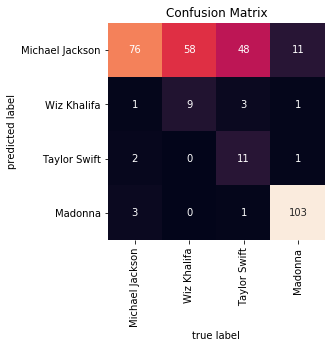

In [502]:
lucem_illud_2020.plotConfusionMatrix(bag, singers_test)

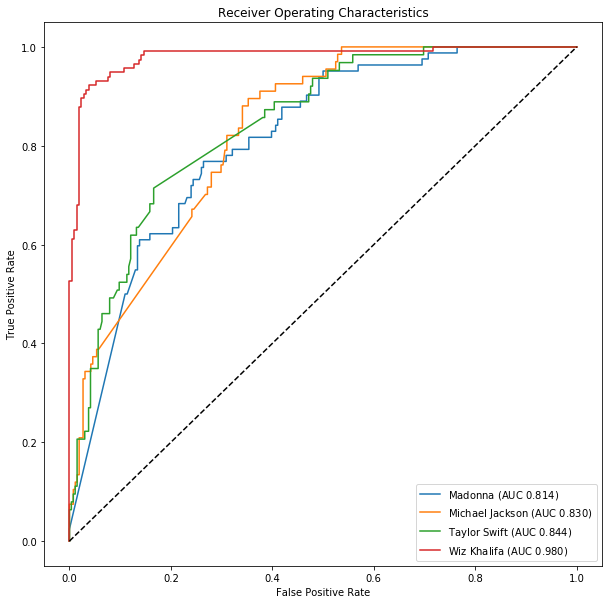

In [503]:
lucem_illud_2020.plotMultiROC(bag, singers_test)

In [532]:
#save result to dataframe
singers_test['rf_predict'] = bag.predict(np.stack(singers_test['vect'], axis=0))
singers_test['rf_predict_prob_true'] = bag.predict_proba(np.stack(singers_test['vect'], axis=0))[:,0]

#evaluate
print('Precision')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['rf_predict'], average='weighted'))
print('Recall')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['rf_predict'], average='weighted'))
print('F1')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['rf_predict'], average='weighted'))

Precision
0.7211132177247325
Recall
0.6067073170731707
F1
0.5651508412352775


    From the above graph and table, we do see that random forest produces much more detailed classification boundary, and that on average, Random Forest performs better than simple decision tree. Random Forest was particularly great at identifying Wiz Khalifa correctly, probably because there are more Wiz Khalifa songs included in the data.
    
    Another interesting thing shown in the confusion matricies is that, both decision tree and random forest classified most of Taylor Swift & Wiz Khalifa's songs as sang by Michael Jackson. However, Madonna tended to be classified as Madonna in both classifiers. This probably shows that Madonna have a very distinct style so  thatshe's not confused with Michael Jackson. However, Taylor Swift & Wiz Khalifa's lyrics share some similarities with Michael Jackson's lyrics.

# K-Nearest Neighbors

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

**In this section, I will build knn with k = 10 and knn with k= 50 and compare their performances.**

In [507]:
#set knn with k=10
knn10 = sklearn.neighbors.KNeighborsClassifier(10, weights='uniform')
#fit the model
knn10.fit(np.stack(singers_train['vect'], axis = 0), singers_train['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [508]:
#evaluate KNN
lucem_illud_2020.evaluateClassifier(knn10, singers_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Madonna,0.237805,0.719512,0.520000,0.421220,0.634146
Taylor Swift,0.195122,0.673555,0.491525,0.329916,0.460317
Wiz Khalifa,0.103659,0.884678,0.859649,0.781133,0.844828
Michael Jackson,0.158537,0.722880,0.636364,0.429990,0.522388


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

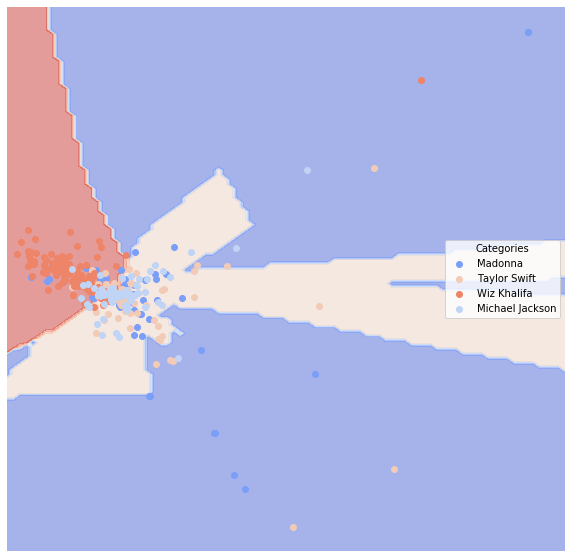

In [509]:
#evaluate KNN
lucem_illud_2020.plotregions(knn10, singers_test)

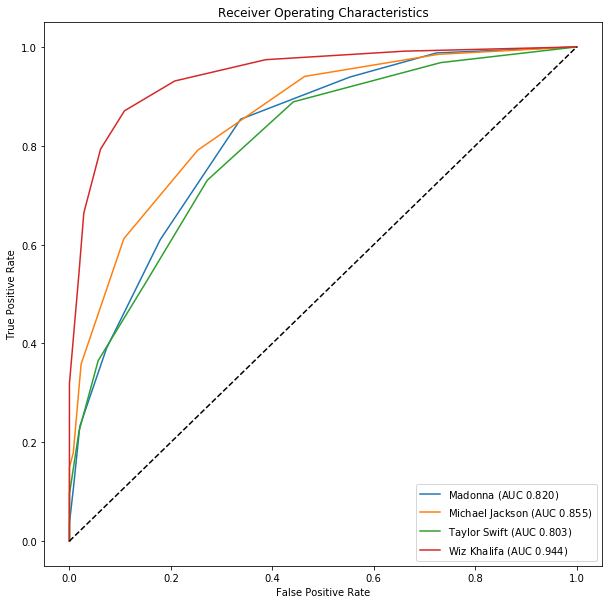

In [510]:
#evaluate KNN
lucem_illud_2020.plotMultiROC(knn10, singers_test)

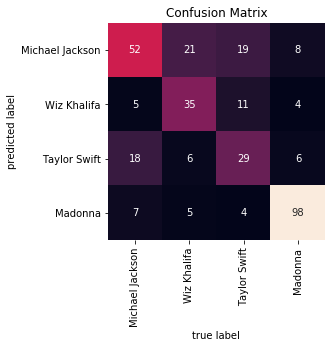

In [511]:
#plot confusion matrix
lucem_illud_2020.plotConfusionMatrix(knn10, singers_test)

In [533]:
#save result to dataframe
singers_test['knn10_predict'] = knn10.predict(np.stack(singers_test['vect'], axis=0))
singers_test['knn10_predict_prob_true'] = knn10.predict_proba(np.stack(singers_test['vect'], axis=0))[:,0]

#evaluate
print('Precision')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['knn10_predict'], average='weighted'))
print('Recall')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['knn10_predict'], average='weighted'))
print('F1')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['knn10_predict'], average='weighted'))

Precision
0.6584200109051613
Recall
0.6524390243902439
F1
0.6527523152229792


    We see that on average, knn with k=10 performed similarly as random forest. 

In [516]:
#set knn with k=50
knn50 = sklearn.neighbors.KNeighborsClassifier(50, weights='uniform')
#fit the model
knn50.fit(np.stack(singers_train['vect'], axis = 0), singers_train['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

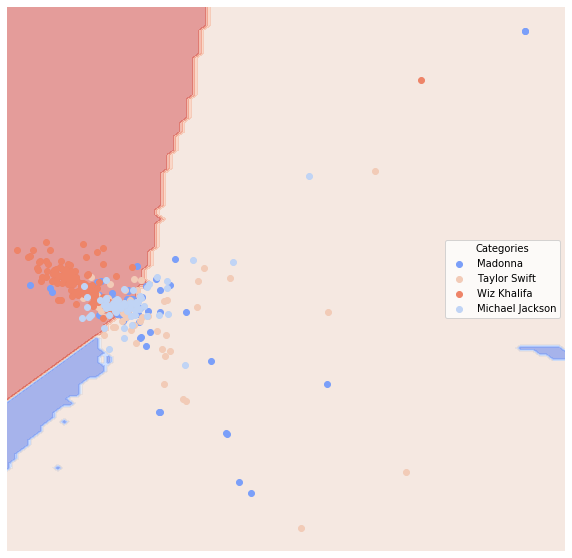

In [518]:
lucem_illud_2020.plotregions(knn50, singers_test)

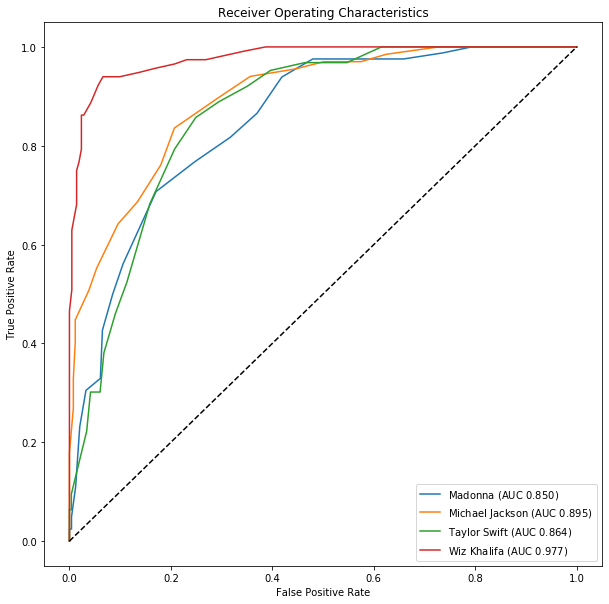

In [519]:
lucem_illud_2020.plotMultiROC(knn50, singers_test)

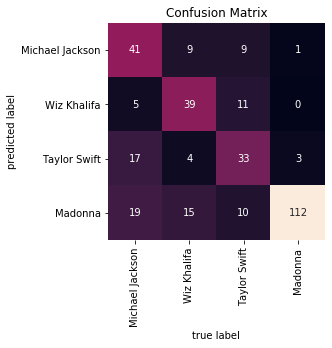

In [520]:
lucem_illud_2020.plotConfusionMatrix(knn50, singers_test)

In [535]:
#save result to dataframe
singers_test['knn50_predict'] = knn50.predict(np.stack(singers_test['vect'], axis=0))
singers_test['knn50_predict_prob_true'] = knn50.predict_proba(np.stack(singers_test['vect'], axis=0))[:,0]

#evaluate
print('Precision:')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['knn50_predict'], average='weighted'))
print('Recall:')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['knn50_predict'], average='weighted'))
print('F1:')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['knn50_predict'], average='weighted'))

Precision:
0.6807870723628104
Recall:
0.6859756097560976
F1:
0.6718524085808925


    Knn with k=50 performed better than knn with k =10 in test data. This shows that taking more neighbors into consideration actually increased the accuracy of the classifier without overfitting the training data. So far,in terms of F1 score, KNN = 50 performed the best among all the classifiers.

# SVM & Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

**Support Vector Machine**

In [536]:
#fit svm
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
clf_svm.fit(np.stack(singers_train['vect'], axis=0), singers_train['category'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

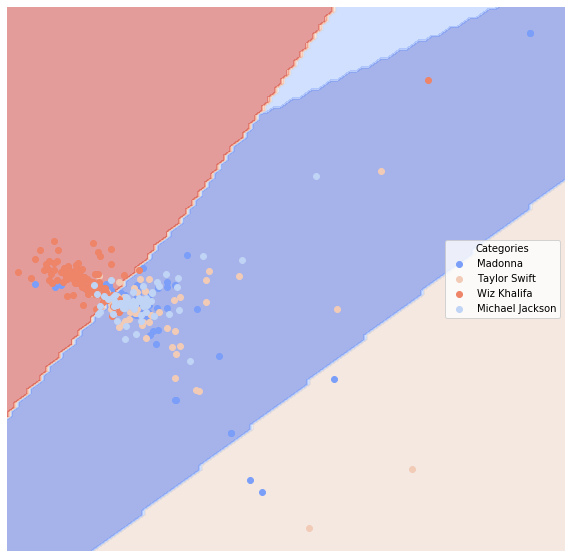

In [537]:
lucem_illud_2020.plotregions(clf_svm, singers_test)

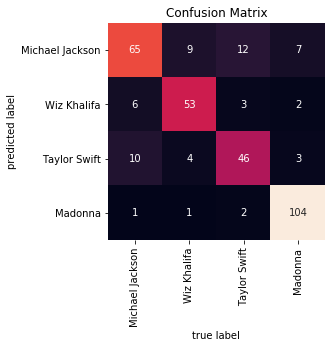

In [539]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, singers_test)

In [540]:
#save result to dataframe
singers_test['svm_predict'] = clf_svm.predict(np.stack(singers_test['vect'], axis=0))

#evaluate
print('Precision:')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['svm_predict'], average='weighted'))
print('Recall:')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['svm_predict'], average='weighted'))
print('F1:')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['svm_predict'], average='weighted'))

Precision:
0.8246948373801614
Recall:
0.8170731707317073
F1:
0.8196411947761789


    Support Vector Machine with linear kerneling performed much better with testing data than all the previous classifiers (with a F1 score of 0.819).  

**MLP**

In [543]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(singers_train['vect'], axis=0), singers_train['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

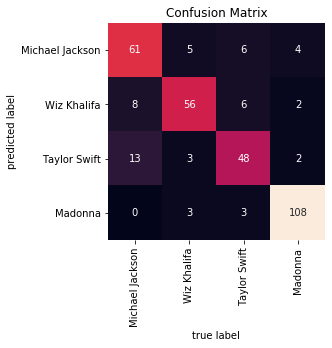

In [545]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, singers_test)

In [544]:
#save result to dataframe
singers_test['nn_predict'] = clf_nn.predict(np.stack(singers_test['vect'], axis=0))

#evaluate
print('Precision:')
print(sklearn.metrics.precision_score(singers_test['category'], singers_test['nn_predict'], average='weighted'))
print('Recall:')
print(sklearn.metrics.recall_score(singers_test['category'], singers_test['nn_predict'], average='weighted'))
print('F1:')
print(sklearn.metrics.f1_score(singers_test['category'], singers_test['nn_predict'], average='weighted'))

Precision:
0.834267741600861
Recall:
0.8323170731707317
F1:
0.8326979224756373


    MLP did equally well when compared with SVM with linear kernel.

    To summarize, Both binary classifiers (logistic regression & naive bayes) performed really well (F1-score = 0.93 on test data).  Among all the other classifiers, Neural Network had the best performance.  KNN =50 also performed better than KNN=10. These results suggest that more complex models are probably better fitted for exploring this lyrics data. There might exist more nuanced differences between singers that can only be captured by more complex models.